# **This notebook use Resnet50 Pretrained**



In [ ]:
import torch
from torchvision.io import read_image
from torchvision.models import resnet50
import datetime as dt

In [ ]:
model_ft = resnet50(pretrained=True)
### strip the last layer because it's for classification
feature_extractor = torch.nn.Sequential(*list(model_ft.children())[:-1])

def load_img(path):
  img = read_image(path)
  img=img.type(torch.float32).unsqueeze(0)# unsqueeze bch twali men 3d l 4d
  return img

def get_embeddings(path):
  img=load_img(path)
  output = feature_extractor(img)
  output=torch.flatten(output)# convert 4d to 1d
  output=output.detach().numpy().tolist()
  return output

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
t = dt.datetime.now()
em1 = get_embeddings('/content/drive/MyDrive/buy_me_that_look/data/images_cropped/shorts/15bce24bfd_1.jpg')
print("Time taken to generate embeddings ",dt.datetime.now()-t)
print(len(em1))

Time taken to generate embeddings  0:00:00.056468
2048


##Elastic search Configuration

In [ ]:
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.10.0-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.10.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.10.0
# start server
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.10.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )

In [ ]:
!pip install elasticsearch==7.10.0

In [ ]:
!curl -X GET "localhost:9200/"

{
  "name" : "f003f1916989",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "bm18bNvzTJOlL3PDC2joDg",
  "version" : {
    "number" : "7.10.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "51e9d6f22758d0374a0f3f5c6e8f3a7997850f96",
    "build_date" : "2020-11-09T21:30:33.964949Z",
    "build_snapshot" : false,
    "lucene_version" : "8.7.0",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
import elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch import helpers

es = Elasticsearch(timeout=2000000000)
es

<Elasticsearch([{}])>

In [ ]:
create_query = {
    "mappings": {
        "properties": {
            "description_vector": {
                "type": "dense_vector",
                "dims": 2048
            }
        }
    }
}
#create index
es.indices.create(index="upper_ware", body=create_query)
#es.indices.create(index="foot_ware", body=create_query)
es.indices.create(index="lower_ware", body=create_query)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'lower_ware'}

##Prepare data 

In [ ]:
#get data from json file
folder = []
json_file =[]

for (root,dirs,files) in os.walk('/content/drive/MyDrive/buy_me_that_look/data/Scrapped/', topdown=False):
  #print(dirs)
  for directory in dirs:
    for i in os.listdir(root+directory):
      #print(i)
      if i.endswith('.json'):
        folder.append(directory)
        json_file.append(i)
        #print(i)
print(folder)#categories name
print(json_file)#file names 

['men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_t-shirts', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_trousers', 'men_tr

In [ ]:
import pandas as pd
import json
import numpy as np

In [ ]:
super_cat = []
cat = []
info = []
file_name = []
url =[]
for i in range(len(json_file)):
  f = open('/content/drive/MyDrive/buy_me_that_look/data/Scrapped/' + folder[i] + '/' + json_file[i] )
  data = json.load(f)
  #for j in data['name']:
  j=data['name']
  #if folder[i]=='men_casual_shorts' or folder[i]=='women_casual_shoes' or folder[i]=='women_flats' or folder[i]=='women_heels':
  #  super_cat.append('foot_ware')
  #  cat.append(folder[i])
  #  info.append(json_file[i])
  #  file_name.append(j)
  #  url.append(data['url'])
  if folder[i]=='men_hoodie'or folder[i]=='men_t-shirts':
    super_cat.append('upper_ware')
    cat.append(folder[i])
    info.append(json_file[i])
    file_name.append(j)
    url.append(data['url'])
  if folder[i]=='men_casual_shorts' or folder[i]=='men_trousers':
    super_cat.append('lower_ware')
    cat.append(folder[i])
    info.append(json_file[i])
    file_name.append(j)
    url.append(data['url'])
  f.close()

In [ ]:
df = pd.DataFrame({ 'id':np.arange(len(file_name)),
                    'super_cat':super_cat,
                   'cat':cat,
                   'info':info,
                   'file_name':file_name,
                   'url':url})
df.head()

,id,super_cat,cat,info,file_name,url
0,0,upper_ware,men_t-shirts,abdee3a327.json,abdee3a327.,https://encrypted-tbn0.gstatic.com/images?q=tb...
1,1,upper_ware,men_t-shirts,9bef3d2e8c.json,9bef3d2e8c.,https://encrypted-tbn0.gstatic.com/images?q=tb...
2,2,upper_ware,men_t-shirts,ac83465fdd.json,ac83465fdd.,https://encrypted-tbn0.gstatic.com/images?q=tb...
3,3,upper_ware,men_t-shirts,e1a598912c.json,e1a598912c.,https://encrypted-tbn0.gstatic.com/images?q=tb...
4,4,upper_ware,men_t-shirts,baffb59de9.json,baffb59de9.,https://encrypted-tbn0.gstatic.com/images?q=tb...


##Transfer to Elastic Search

In [ ]:
#genrate docs and embedding to transfer to Elastic search
docs = []
c = 0
t = dt.datetime.now()
for row in df.iterrows():
  json_obj = {}
  path = root + row[1]['cat']+'/' + row[1]['file_name']+'jpg'
  print('path: ',path)
  em = get_embeddings(path)
  json_obj['_index']=row[1]['super_cat']
  json_obj['_id']=row[1]['id']
  json_obj['url'] = row[1]['url']
  json_obj['cat'] = row[1]['cat']
  json_obj['file_name'] = row[1]['file_name']+'jpg'
  json_obj['description_vector'] = em
  docs.append(json_obj)
  c+=1
  if c%50==0:
    print(c)
    print(dt.datetime.now()-t)


path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/abdee3a327.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/9bef3d2e8c.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/ac83465fdd.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/e1a598912c.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/baffb59de9.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/06ea13e281.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/931974ff91.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/8ba9200afd.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/191fc00090.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/8411a03fbd.jpg
path:  /content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_t-shirts/a996078e33.jpg
path:  /content/drive

In [ ]:
print(len(docs))#docs fiha embeddings mtaa tsawer scrapped kol 
print(docs[0:5])

170
[{'_index': 'upper_ware', '_id': 0, 'url': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTTAXlVr6nkkit-dhLg3tAxTo1_cSys8knjiw&usqp=CAU', 'cat': 'men_t-shirts', 'file_name': 'abdee3a327.jpg', 'description_vector': [0.33866822719573975, 0.541487455368042, 0.4526079595088959, 0.4041709303855896, 0.5302509665489197, 0.5628822445869446, 0.5298670530319214, 0.44892802834510803, 0.40770840644836426, 0.3661380708217621, 0.27287980914115906, 0.40389198064804077, 0.5248210430145264, 0.5896231532096863, 0.44890570640563965, 0.514582097530365, 0.5355202555656433, 0.295716255903244, 0.361542671918869, 0.3863677978515625, 0.3666573762893677, 0.45016592741012573, 0.46933263540267944, 0.4112869203090668, 0.5571970343589783, 0.5308226943016052, 0.4374253451824188, 0.4203580319881439, 0.445687860250473, 0.39511221647262573, 0.3825112581253052, 0.37337416410446167, 0.37023261189460754, 0.43150654435157776, 0.692442774772644, 0.4400276243686676, 0.45958518981933594, 0.5163859724998474, 0.4133

In [ ]:
#transfer all embeddings to Elastic Search
helpers.bulk(es, docs) 

(170, [])

In [ ]:
#Search query (we will now search for similar products)
def search_similar_image(query_vec,index_label):
  search_query = {
      "size": 20,
      "_source": {
          "includes": ["file_name","url"]
      },
      "query": {
          "script_score": {
              "query": {
                  "match_all": {}
              },
              "script": {
                  #"source": "cosineSimilarity(params.queryVector, 'description_vector') + 1.0",
                  "source": "1 / l2norm(params.queryVector,'description_vector') + 1.0",
                  "params": {
                      "queryVector": query_vec
                  }
              }
          }
      }
  }
  response = es.search(
      index= index_label,
      body=search_query
  )

  return response

In [ ]:
query_vec = get_embeddings('/content/drive/MyDrive/buy_me_that_look/data/images_cropped/shorts/5e1e886c55_0.jpg')

In [ ]:
index_label = 'lower_ware'
response = search_similar_image(query_vec,index_label)

In [ ]:
response

{'took': 55,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 80, 'relation': 'eq'},
  'max_score': 1.7309829,
  'hits': [{'_index': 'lower_ware',
    '_type': '_doc',
    '_id': '162',
    '_score': 1.7309829,
    '_source': {'file_name': '7ef0ae79ab.jpg',
     'url': 'https://image.made-in-china.com/202f0j00YbPuEdnJhQgq/Wholesale-New-design-Casual-Shorts-Workout-Fashion-Sweat-Comfy-Shorts-Summer-Breathable-Loose-Shorts-for-Mens.jpg'}},
   {'_index': 'lower_ware',
    '_type': '_doc',
    '_id': '62',
    '_score': 1.590206,
    '_source': {'file_name': 'd1419198dd.jpg',
     'url': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTIjK3pNp7TYBRuYHQOEd1DlbD32x6NkQYpaQ&usqp=CAU'}},
   {'_index': 'lower_ware',
    '_type': '_doc',
    '_id': '139',
    '_score': 1.5836033,
    '_source': {'file_name': '58767c5f89.jpg',
     'url': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSkZFGd6ZqInUk4EZeb-AMJxfrc5

##Visualisation 

In [ ]:
import cv2,json
import matplotlib.pyplot as plt
import io
from PIL import Image
import requests
import numpy as np
#import urllib.request
#utility finctions

def print_recommendations(response):
  c=1
  flag = []
  li=[]
  def url_to_image(link):
    image_url = link
    image_content = requests.get(image_url).content
    image_file = io.BytesIO(image_content)
    #image = Image.open(image_file).convert('RGB')
    
    image=np.array(Image.open(image_file).convert('RGB'))
    #print(image)
    
    return image


  def get_image_links(n,df):
    id = int(n)
    root = '/content/drive/MyDrive/buy_me_that_look/data/Scrapped/'
    path = root + df['cat'][id] + '/' + df['info'][id]
    print(path)
    f = open(path)
    data = json.load(f)
    li.append(data['url']) #kenet data['links']
    f.close()
    return li


  def plot_images(li):
      fig, ax = plt.subplots(1,len(li), figsize=(4,4))
      if len(li)==1:
        outimage = li[0]
        auto_show = True
        height, width = outimage.shape[:2]
        ax.set_ylim(height + 10, -10)
        ax.set_xlim(-10, width + 10)
        ax.axis('off')
        img1 = outimage.astype(np.uint32).copy()
        ax.imshow(img1.astype(np.uint8))
        plt.show()
      else:

        for i in range(len(li)): 
          outimage = li[i]
          auto_show = True
          height, width = outimage.shape[:2]
          ax[i].set_ylim(height + 10, -10)
          ax[i].set_xlim(-10, width + 10)
          ax[i].axis('off')
          img1 = outimage.astype(np.uint32).copy()
          ax[i].imshow(img1.astype(np.uint8))
        plt.show()
  


  for i in response['hits']['hits']:
    url = i['_source']['url']
    id = i['_id']
    
    if url not in flag:
      
      flag.append(url)
      links = get_image_links(int(id),df)
      images = []
      for j in links:
        #print(j)
        #try:
        images=[] # hethi l zedtha ena tkhali ken l append le5rania
        #print('hhhhhh')
        img = url_to_image(j)
        images.append(img)
        #except:
        #  print('j=',j)
        #  print('links= ',links)
      #print(images)
      print(f"recomendation {c}")
      print("You can buy product from below link")
      print(url)
      print("="*200)
      plot_images(images)
      print('longueur de images= ',len(images))
      print("="*200)
      c+=1
      if c==6:
        break

/content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_casual_shorts/7ef0ae79ab.json
recomendation 1
You can buy product from below link
https://image.made-in-china.com/202f0j00YbPuEdnJhQgq/Wholesale-New-design-Casual-Shorts-Workout-Fashion-Sweat-Comfy-Shorts-Summer-Breathable-Loose-Shorts-for-Mens.jpg


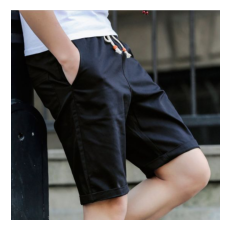

longueur de images=  1
/content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_trousers/d1419198dd.json
recomendation 2
You can buy product from below link
https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTIjK3pNp7TYBRuYHQOEd1DlbD32x6NkQYpaQ&usqp=CAU


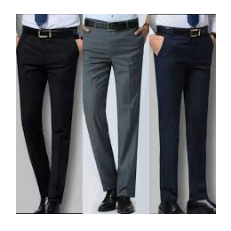

longueur de images=  1
/content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_casual_shorts/58767c5f89.json
recomendation 3
You can buy product from below link
https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSkZFGd6ZqInUk4EZeb-AMJxfrc5aK71k7hZg&usqp=CAU


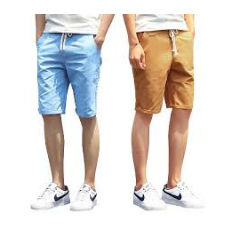

longueur de images=  1
/content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_casual_shorts/2175ce9f15.json
recomendation 4
You can buy product from below link
https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSO_ZWlBmlvgJr132qTqucYsfZ7X7EUdjs3gw&usqp=CAU


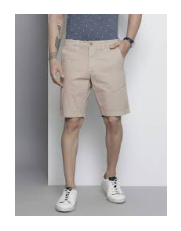

longueur de images=  1
/content/drive/MyDrive/buy_me_that_look/data/Scrapped/men_trousers/ba6f7df8c1.json
recomendation 5
You can buy product from below link
https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS6clt1ZeKtOsjbgMQAMb2kTq1JvGjifP22MA&usqp=CAU


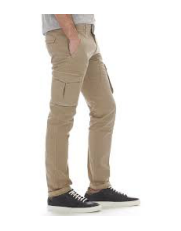

longueur de images=  1


In [ ]:
print_recommendations(response)